In [204]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set up matplotlib
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 5)
colors = sns.color_palette()

# Trocha teorie

- stochastická optimalizační strategie
  - (stochasticita ale není klíčem k úspěchu a deterministické varianty existují)
- uvažuje pouze jednu konfiguraci (stav) najednou
- inspirované tuhnutím taveniny, fyzickými procesy krystalizace při ochlazování
- často se používá v diskrétních stavových prostorech
  - moc toho po stavovém prostoru nechce, narozdíl např. od gradient descent, který potřebuje derivaci
- jednoduchý princip:
  1. Teplota se pomalu snižuje od počáteční hodnoty k nule.
  2. Algoritmus v každém kroku vybere náhodné řešení sousední k aktuálnímu,
  3. změří kvalitu vybraného souseda
  4. a přesune se do tohoto sousedního řešení v *závislosti na teplotě a jeho kvalitě*

# Simulated annealing for vertex cover

In [254]:
n_vertices = 17
graph = []

In [251]:
# an almost complete graph
for i in range(n_vertices):
    for j in range(n_vertices):
        if i != j and np.random.rand() < 0.8:
            graph.append((i, j))


In [255]:
# a star
for i in range(n_vertices):
    if i != 0:
        graph.append((0, i))


In [258]:
# a tree
for i in range(n_vertices):
    if i != 0:
        graph.append((np.random.randint(0, i), i))

In [209]:
# a valid solution covers all edges
def valid_solution(x):
    for i, j in graph:
        if x[i] == 0 and x[j] == 0:
            return False
    return True

In [259]:
# find the optimal vertex cover
def find_vertex_cover(initial, i = 0):
    if i == n_vertices:
        if valid_solution(initial):
            return [sum(initial), initial]
        return None
    # consider including the i-th vertex
    included = initial.copy()
    included[i] = 1
    cover1 = find_vertex_cover(included, i + 1)

    # consider excluding the i-th vertex
    cover2 = find_vertex_cover(initial, i + 1)

    # check which cover is better
    if cover1 is None or (cover2 is not None and cover1[0] > cover2[0]):
        return cover2
    return cover1

print(find_vertex_cover(np.zeros(n_vertices)))

[7.0, array([1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.])]


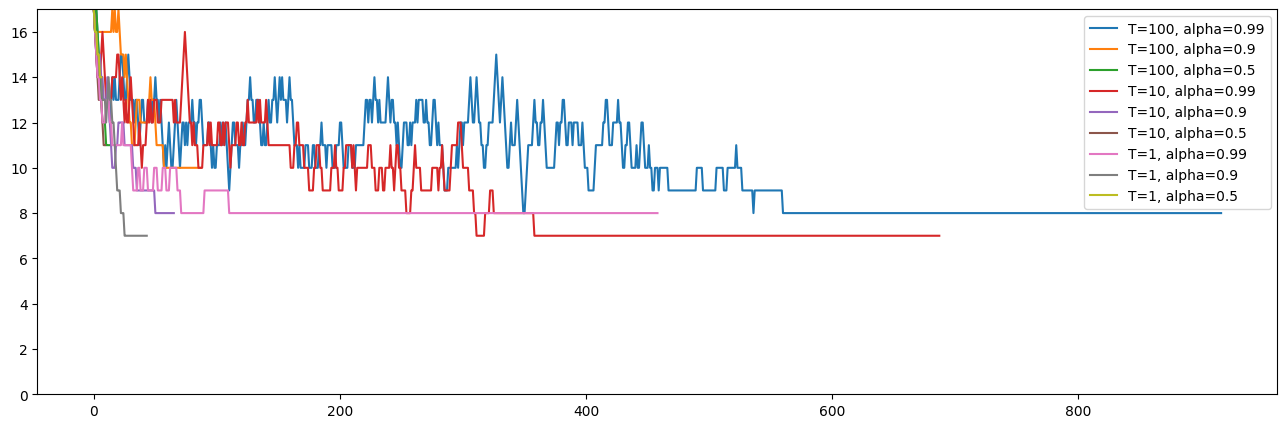

In [260]:
# the cost is the number of vertices in the solution
def cost_function(x):
    return sum(x)

# custom implementation of simulated annealing with explanatory comments
def simulated_annealing(cost_function, initial_solution, T=100, alpha=0.99, max_iter=1000):
    solution = initial_solution.copy()
    # initialize the fitness curve
    fitness_curve = []
    i = 0
    # iterate until the temperature is zero
    while T > 0.01 and i < max_iter:
        new_solution = solution.copy()
        # randomly select and flip a vertex
        i = np.random.randint(0, n_vertices)
        new_solution[i] = 1 - new_solution[i]

        # compare costs
        cost = cost_function(solution)
        cost_new = cost_function(new_solution)
        delta_cost = cost_new - cost

        # ignore invalid solutions
        if not valid_solution(new_solution):
            pass
        # if the new solution is better, accept it
        elif delta_cost < 0:
            solution = new_solution
        # if the new solution is worse, accept it with a probability of e^(-delta_cost/T)
        elif np.random.rand() < np.exp(-delta_cost / T):
            solution = new_solution
        # append the current cost to the fitness curve
        fitness_curve.append(cost)
        # decrease the temperature
        T = alpha * T
        i += 1
    # return the best solution and the fitness curve
    return solution, fitness_curve

# initial solution
x0 = np.ones(n_vertices)

# try the following for various values of T and alpha, put labels on the plot
for T in [100, 10, 1]:
    for alpha in [0.99, 0.9, 0.5]:
        x, fitness_curve = simulated_annealing(cost_function, x0, T=T, alpha=alpha)
        plt.plot(fitness_curve, label='T={}, alpha={}'.format(T, alpha))

plt.ylim(0, n_vertices)
plt.legend()
plt.show()


# Simulated annealing for hill climbing

Sousedi stavu: +- 10 bodů nalevo či napravo, stavový prostor je efektivně cyklus s přechody navíc

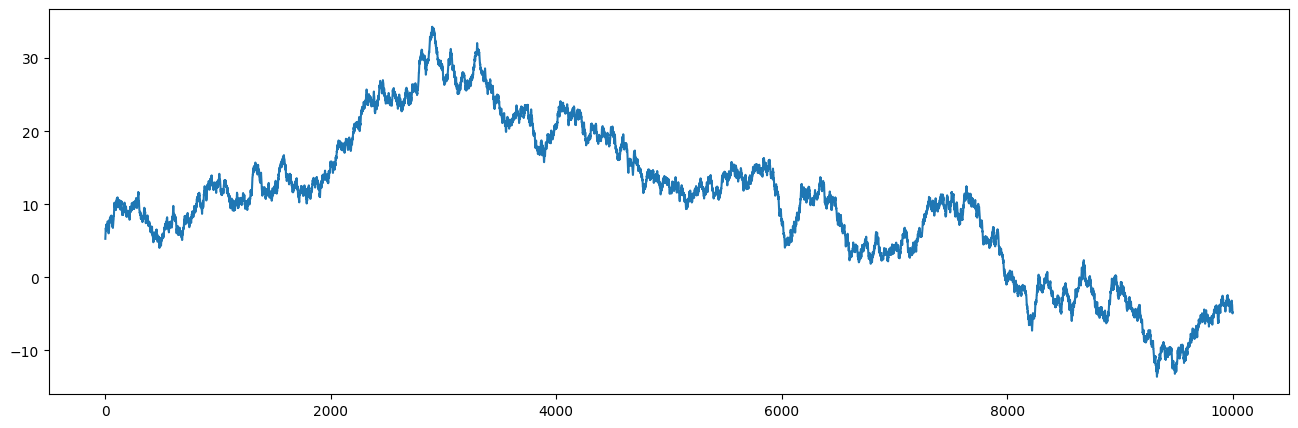

In [224]:
# random curve
n_vertices = 10000
curve = []
pos = 5
for i in range(n_vertices):
    pos += np.random.rand() - 0.5
    curve.append(pos)

plt.plot(curve)


In [240]:
# hill climbing by simulated annealing

# the cost is the neg altitude of the vertex
def cost_function(x):
    return -curve[x]

def hill_climbing(cost_function, initial_solution, T=100, alpha=0.99, max_iter=1000):
    solution = initial_solution
    fitness_curve = []
    i = 0
    while T > 0.01 and i < max_iter:
        # randomly jump elsewhere in the curve
        new_solution = (solution + np.random.randint(-50, 50)) % n_vertices

        # compare costs
        cost = cost_function(solution)
        cost_new = cost_function(new_solution)
        delta_cost = cost_new - cost

        # no validity check: every vertex is a valid position

        # if the new solution is better, accept it
        if delta_cost < 0:
            solution = new_solution
        elif np.random.rand() < np.exp(-delta_cost / T):
            solution = new_solution
        # append the current cost to the fitness curve
        fitness_curve.append(cost)
        # decrease the temperature
        T = alpha * T
        i += 1
    return solution, fitness_curve

# initial solution
x0 = 0

## Jak to půjde s podobnými parametry?


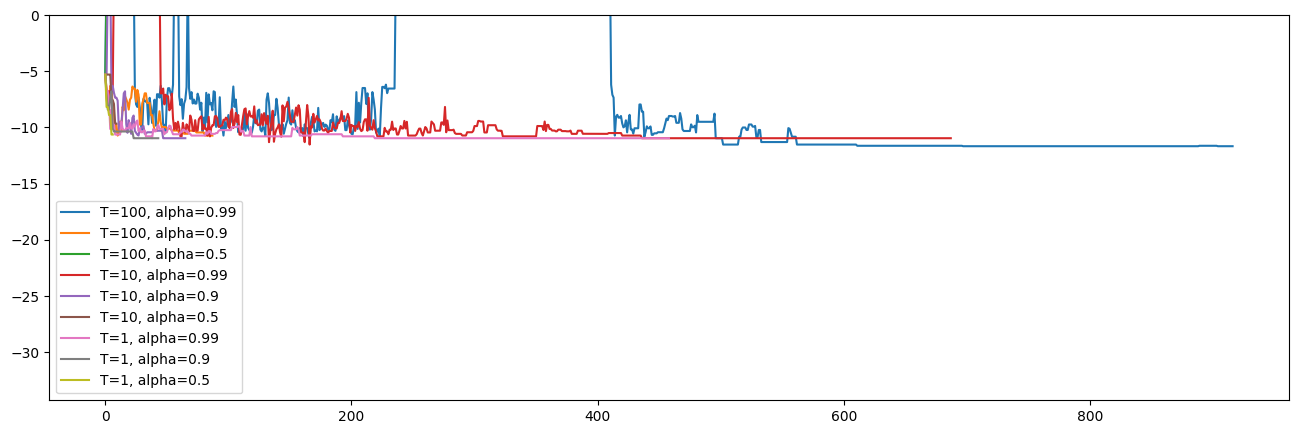

In [241]:
# try the following for various values of T and alpha, put labels on the plot
best = np.inf
best_x = None
for T in [100, 10, 1]:
    for alpha in [0.99, 0.9, 0.5]:
        x, fitness_curve = hill_climbing(cost_function, x0, T=T, alpha=alpha)
        if cost_function(x) < best:
            best = cost_function(x)
            best_x = x
        plt.plot(fitness_curve, label='T={}, alpha={}'.format(T, alpha))

plt.ylim(-max(curve), 0)
plt.legend()
plt.show()

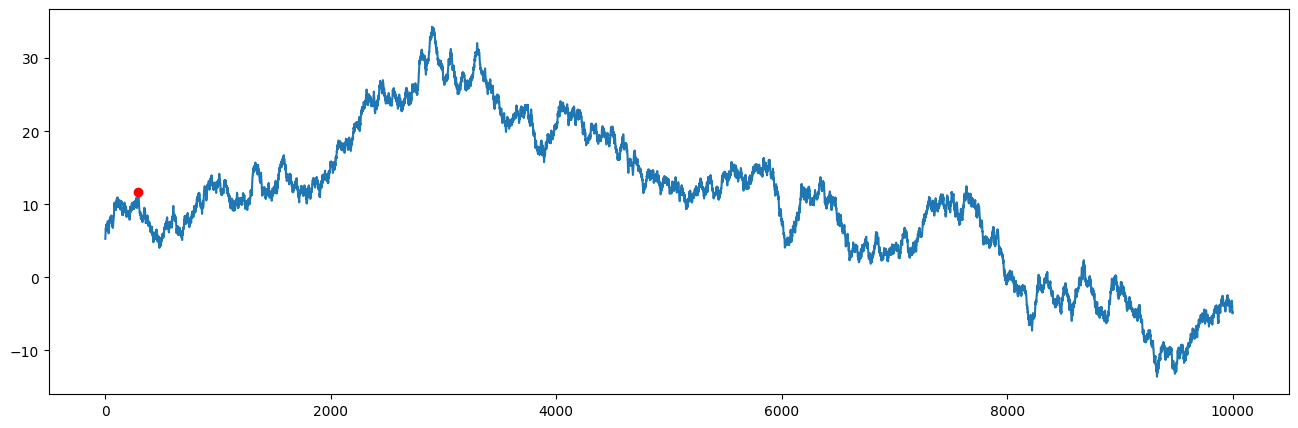

The best solution is at x = 293, with cost = -11.667604383990742
The actual optimum is at x = 2900, with cost = -34.30897001110112


In [242]:
# plot the optimum on the curve
plt.plot(curve)
plt.plot(best_x, curve[best_x], 'ro')
plt.show()

print('The best solution is at x = {}, with cost = {}'.format(best_x, best))
print('The actual optimum is at x = {}, with cost = {}'.format(np.argmax(curve), -max(curve)))

Bohužel nic moc.

## Vyšší teplota, pomalejší chlazení

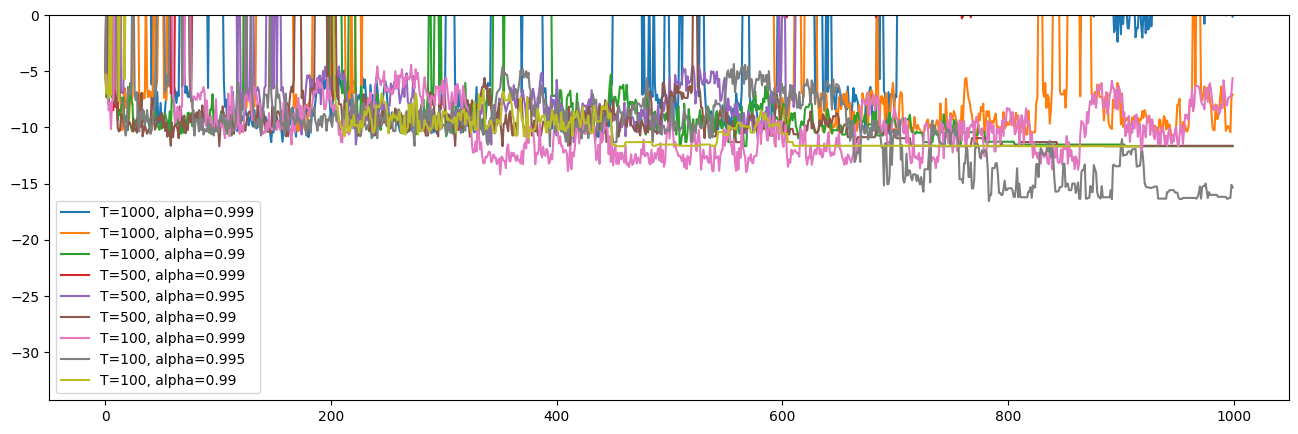

In [244]:
# try the following for various values of T and alpha, put labels on the plot
best = np.inf
best_x = None
for T in [1000, 500, 100]:
    for alpha in [0.999, 0.995, 0.99]:
        x, fitness_curve = hill_climbing(cost_function, x0, T=T, alpha=alpha)
        if cost_function(x) < best:
            best = cost_function(x)
            best_x = x
        plt.plot(fitness_curve, label='T={}, alpha={}'.format(T, alpha))

plt.ylim(-max(curve), 0)
plt.legend()
plt.show()

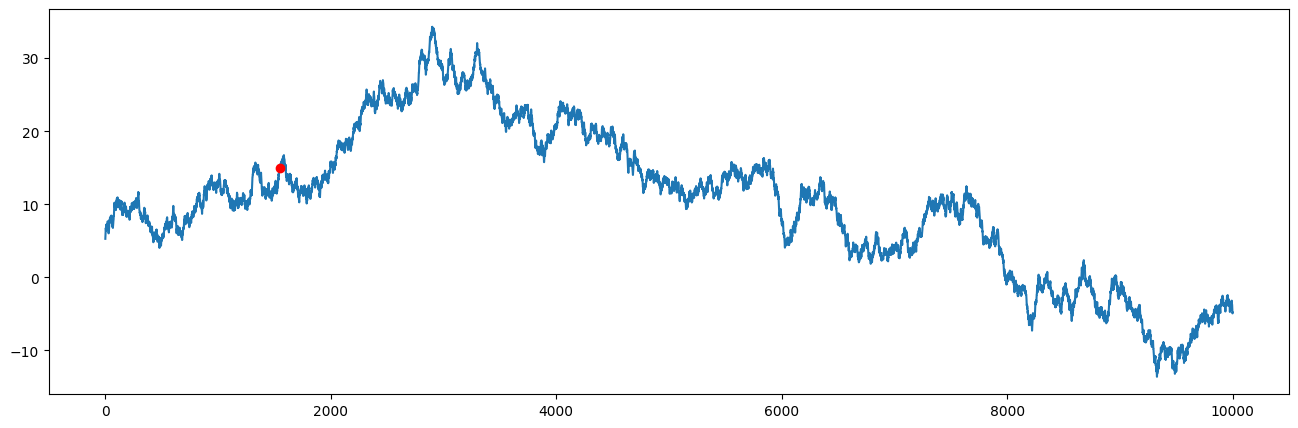

The best solution is at x = 1546, with cost = -15.006542886992802
The actual optimum is at x = 2900, with cost = -34.30897001110112


In [245]:
# plot the optimum on the curve
plt.plot(curve)
plt.plot(best_x, curve[best_x], 'ro')
plt.show()

print('The best solution is at x = {}, with cost = {}'.format(best_x, best))
print('The actual optimum is at x = {}, with cost = {}'.format(np.argmax(curve), -max(curve)))

Někam jsme se posunuli, ale graf pořád hodně skáče blízko limitu počtu iterací.

## Popusťme uzdu `for` smyčce

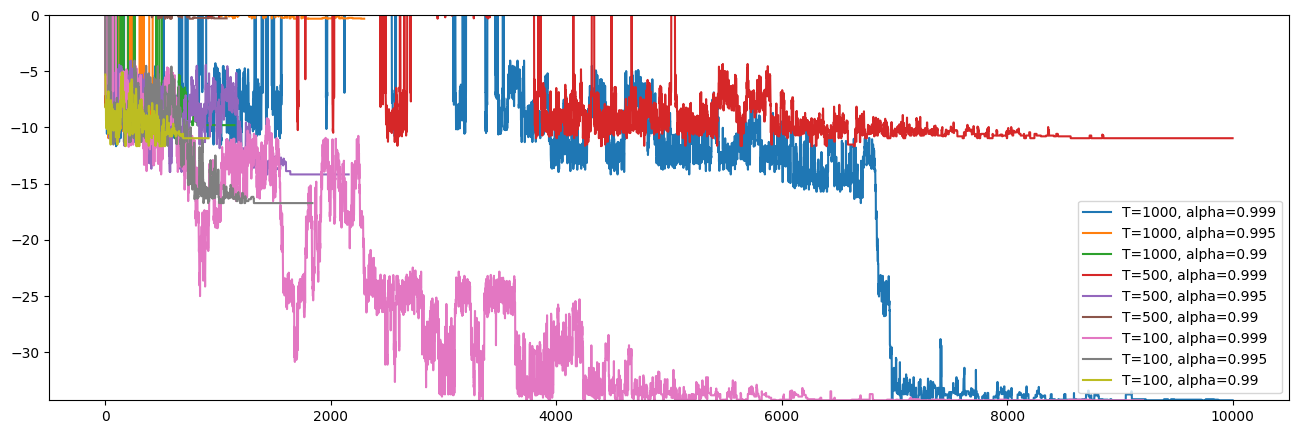

In [248]:
# try the following for various values of T and alpha, put labels on the plot
best = np.inf
best_x = None
for T in [1000, 500, 100]:
    for alpha in [0.999, 0.995, 0.99]:
        x, fitness_curve = hill_climbing(cost_function, x0, T=T, alpha=alpha, max_iter=10000)
        if cost_function(x) < best:
            best = cost_function(x)
            best_x = x
        plt.plot(fitness_curve, label='T={}, alpha={}'.format(T, alpha))

plt.ylim(-max(curve), 0)
plt.legend()
plt.show()

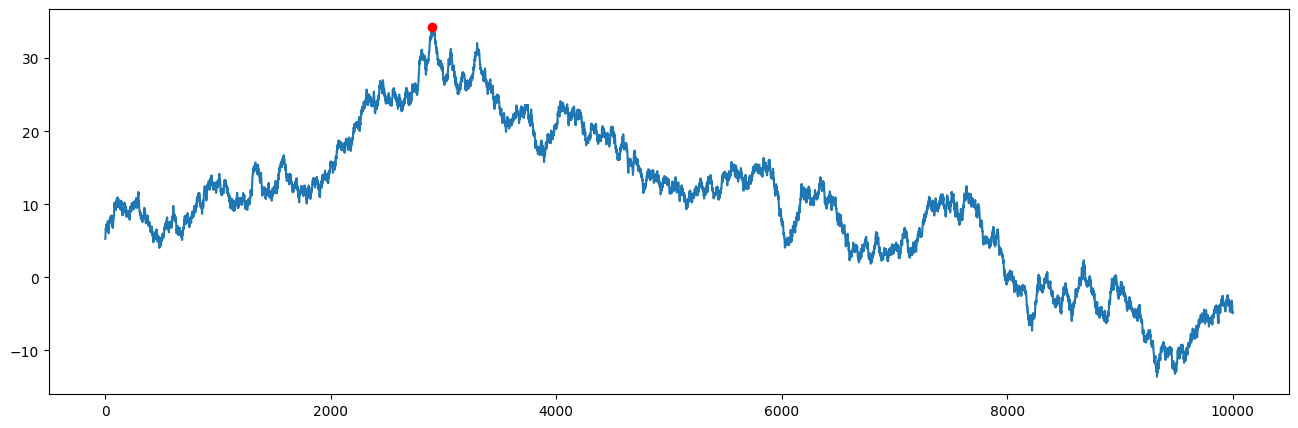

The best solution is at x = 2900, with cost = -34.30897001110112
The actual optimum is at x = 2900, with cost = -34.30897001110112


In [249]:
# plot the optimum on the curve
plt.plot(curve)
plt.plot(best_x, curve[best_x], 'ro')
plt.show()

print('The best solution is at x = {}, with cost = {}'.format(best_x, best))
print('The actual optimum is at x = {}, with cost = {}'.format(np.argmax(curve), -max(curve)))